# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
import cv2
import random

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = str(len(X_test[0])) + ' x ' + str(len(X_test[0][0]))

# TODO: how many classes are in the dataset
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32 x 32
Number of classes = 43


In [ ]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plot

In [ ]:
plot.hist(y_train, bins=n_classes)
plot.title('Training Examples per Class')
plot.xlabel('Class')
plot.ylabel('Frequency')
plot.show()

In [ ]:
plot.hist(y_test, bins=n_classes)
plot.title('Tests per Class')
plot.xlabel('Class')
plot.ylabel('Frequency')
plot.show()

In [ ]:
class_examples = [None] * n_classes

for i in range(len(y_test)):
    class_number = y_test[i]
    class_examples[class_number] = X_test[i]
   
def show_img_plot_gray(name, img, figure_num):
    plot.figure(figure_num)
    plot.imshow(img, cmap='gray')
    plot.title(name)
    plot.show()

def show_img_plot(name, img, figure_num):
    plot.figure(figure_num)
    plot.imshow(img)
    plot.title(name)
    plot.show()
    
for i in range(n_classes):
    class_example = class_examples[i]
    show_img_plot('Class ' + str(i), class_example, i * 10)
    # V of HSV
    img = cv2.cvtColor(class_example.copy(), cv2.COLOR_RGB2HSV)
    img = img[:,:,2]
    show_img_plot_gray('Class ' + str(i) + ' V of HSV', img, i * 10 + 1)
    # L of HLS
    img = cv2.cvtColor(class_example.copy(), cv2.COLOR_RGB2HLS)
    img = img[:,:,1]
    show_img_plot_gray('Class ' + str(i) + ' L of HLS', img, i * 10 + 2)
    # Y of YUV
    img = cv2.cvtColor(class_example.copy(), cv2.COLOR_RGB2YUV)
    img = img[:,:,0]
    show_img_plot_gray('Class ' + str(i) + ' Y of YUV', img, i * 10 + 3)
    # R of RGB
    img = class_example[:,:,0]
    show_img_plot_gray('Class ' + str(i) + ' R of RGB', img, i * 10 + 4)
    # B of RGB
    img = class_example[:,:,2]
    show_img_plot_gray('Class ' + str(i) + ' B of RGB', img, i * 10 + 5)
    # grayscale
    img = cv2.cvtColor(class_example.copy(), cv2.COLOR_RGB2GRAY)
    show_img_plot_gray('Class ' + str(i) + ' grayscale', img, i * 10 + 6)
    # Canny
    img = cv2.Canny(img, 50, 150)
    show_img_plot_gray('Class ' + str(i) + ' grayscale + canny', img, i * 10 + 7)
    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Notes:

Possible pre-processing techniques:
(from attached paper)
- grayscale
- convert to YUV and take Y
- convert to YUV and normalize Y only
- global and local contrast normalization

From comparison above, Y of YUV, L of HLS look best, followed by grayscale
V of HSV does not seem to work for some cases
R or B of RGB seem to provide better contrast in some very dark edge cases

Conclusion: L of HLS looks just a bit more distinguishable visually, so going with that

Possible data generation methods:
(from attached paper)
- jittering (random perturbation translate [-2,2] pixles; scale [.9, 1.1]; rotate [-15,+15] degrees)
- suggested to try perturbations of brightness, contrast, blur
(my ideas)
- create a class of non-sign images which are random 32x32 images in RGB, # of samples should be ~ avg # of samples per class

In [3]:
# create jittered duplicates (for training set only)
import random

# returns img copy randomly jittered
def jitter(source):
    # rotate
    # add padding and copy img into center
    border = 8
    new_dim = 32 + 2*border
    frame = cv2.copyMakeBorder(np.zeros((new_dim, new_dim, 3)), border, border, border, border, cv2.BORDER_CONSTANT, value=[127, 127, 127])

    for i in range(border, border + 32):
        for j in range(border, border + 32):
            frame[i][j] = source[i - border][j - border]

    rotation_deg = random.uniform(-15, 15)
    height, width = frame.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), rotation_deg, 1.0)
    frame = cv2.warpAffine(frame, rotation_matrix, (width, height))

    # extract from center
    img = frame[border:border + 32, border:border + 32]

    # translate (fill emptied row/column with nearest row or original image)
    translation_dim1 = random.randint(-2, 2)
    dim1_order = list(range(32))
    if translation_dim1 > 0:
        dim1_order = [0] * translation_dim1 + dim1_order[:-translation_dim1]
    elif translation_dim1 < 0:
        dim1_order = dim1_order[-translation_dim1:] + [dim1_order[-1]] * -translation_dim1

    translation_dim2 = random.randint(-2, 2)
    dim2_order = list(range(32))
    if translation_dim2 > 0:
        dim2_order = [0] * translation_dim2 + dim2_order[:-translation_dim2]
    elif translation_dim2 < 0:
        dim2_order = dim2_order[-translation_dim2:] + [dim2_order[-1]] * -translation_dim2

    img = np.array([[img[i][j] for j in dim2_order] for i in dim1_order])

    # scale
    scale = random.uniform(0.9, 1.1)
    # pixels, rounded to even pixel value to assist cropping
    new_size = round(scale * 32 / 2) * 2
    scaled_img = cv2.resize(img, (new_size, new_size))

    margin = round(abs(new_size - 32) / 2)
    index_max = 31 - margin
    if new_size > 32:
        img = scaled_img[margin:(margin + 32), margin:(margin + 32)]
    elif new_size < 32:
        # fill center of old image with new image
        for i in range(len(img)):
            for j in range(len(img[0])):
                if i >= margin and i <= index_max and j >= margin and j <= index_max:
                    img[i][j] = scaled_img[i - margin][j - margin]

    return img

# 5 jittered versions + original img
n_train = len(y_train)

X_train = np.resize(X_train, (n_train * 6, 32, 32, 3))
y_train = np.resize(y_train, n_train * 6)

for i in range(n_train):
    if i % 1000 == 0: print('processing image', i)
    for j in range(1, 6):
        new_index = j * n_train + i
        X_train[new_index] = jitter(X_train[i])
        y_train[new_index] = y_train[i]

# multiply examples by 6 (original + 5 jittered)
print('done generating additional data', len(X_train))

processing image 0
processing image 1000
processing image 2000
processing image 3000
processing image 4000
processing image 5000
processing image 6000
processing image 7000
processing image 8000
processing image 9000
processing image 10000
processing image 11000
processing image 12000
processing image 13000
processing image 14000
processing image 15000
processing image 16000
processing image 17000
processing image 18000
processing image 19000
processing image 20000
processing image 21000
processing image 22000
processing image 23000
processing image 24000
processing image 25000
processing image 26000
processing image 27000
processing image 28000
processing image 29000
processing image 30000
processing image 31000
processing image 32000
processing image 33000
processing image 34000
processing image 35000
processing image 36000
processing image 37000
processing image 38000
processing image 39000
done generating additional data 235254


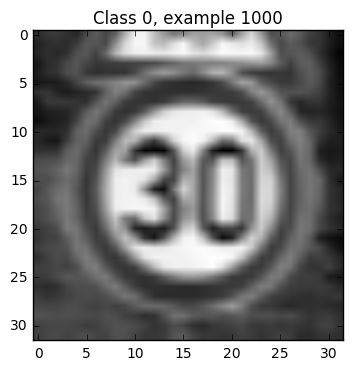

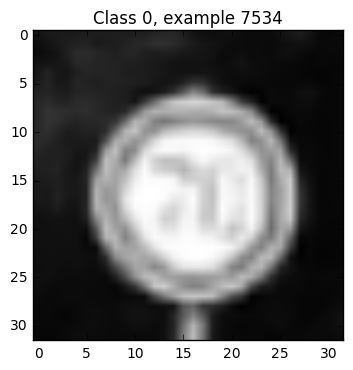

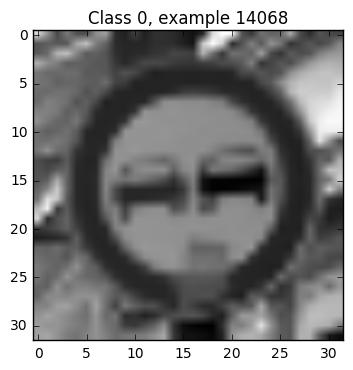

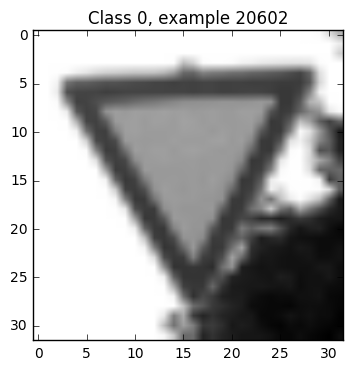

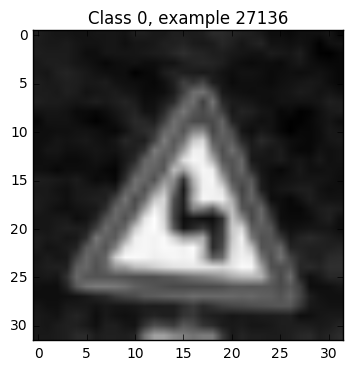

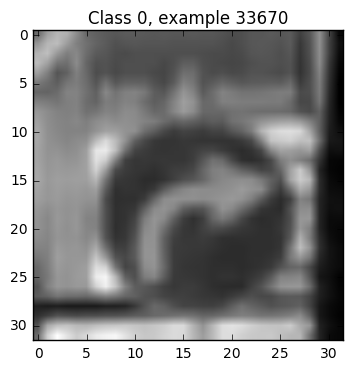

In [5]:
# sanity check for jittered imgs
import matplotlib.pyplot as plot

def show_img_plot_gray(name, img, figure_num):
    plot.figure(figure_num)
    plot.imshow(img, cmap='gray')
    plot.title(name)
    plot.show()
    
for i in range(1000, n_train, int(n_train / 6)):
    show_img_plot_gray('Class 0, example ' + str(i), X_train[i], i)

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def single_channel_L_HLS(data):
    result = np.empty([len(data), 32, 32])
    for i in range(len(data)):
        result[i] = cv2.cvtColor(data[i], cv2.COLOR_RGB2HLS)[:,:,1]
    return result

# convert RGB to L of HLS
# data was n*32*32*3, now n*32*32
X_train = single_channel_L_HLS(X_train)
X_test = single_channel_L_HLS(X_test)
print('done converting to single channel')

done converting to single channel


In [6]:
def global_normalize(data):
    for i in range(len(data)):
        data[i] = cv2.normalize(data[i], data[i], alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# normalize pixels to [-0.5, 0.5]
global_normalize(X_train)
global_normalize(X_test)
print('done normalizing')

done normalizing


In [ ]:
# pickle preprocessed data without additional data
import pickle

with open('x_train_normalized_1.p', mode='wb') as f:
    pickle.dump(X_train, f)
with open('y_train_normalized_1.p', mode='wb') as f:
    pickle.dump(y_train, f)  
with open('x_test_normalized_1.p', mode='wb') as f:
    pickle.dump(X_test, f)
with open('y_test_normalized_1.p', mode='wb') as f:
    pickle.dump(y_test, f)

print('preprocessed data without additional data saved')

In [ ]:
# pickle preprocessed data with additional data
import pickle

with open('x_train_normalized_2.p', mode='wb') as f:
    pickle.dump(X_train, f)
with open('y_train_normalized_2.p', mode='wb') as f:
    pickle.dump(y_train, f)  
with open('x_test_normalized_2.p', mode='wb') as f:
    pickle.dump(X_test, f)
with open('y_test_normalized_2.p', mode='wb') as f:
    pickle.dump(y_test, f)

print('preprocessed data with additional data saved')

In [2]:
# unpickle preprocessed data without additional data
import pickle

with open('x_train_normalized_1.p', mode='rb') as f:
    X_train = pickle.load(f)
with open('y_train_normalized_1.p', mode='rb') as f:
    y_train = pickle.load(f)  
with open('x_test_normalized_1.p', mode='rb') as f:
    X_test = pickle.load(f)
with open('y_test_normalized_1.p', mode='rb') as f:
    y_test = pickle.load(f)
    
print('preprocessed data without additional data loaded')

preprocessed data loaded


In [ ]:
# unpickle preprocessed data with additional data
import pickle

with open('x_train_normalized_2.p', mode='rb') as f:
    X_train = pickle.load(f)
with open('y_train_normalized_2.p', mode='rb') as f:
    y_train = pickle.load(f)  
with open('x_test_normalized_2.p', mode='rb') as f:
    X_test = pickle.load(f)
with open('y_test_normalized_2.p', mode='rb') as f:
    y_test = pickle.load(f)
    
print('preprocessed data with additional data loaded')

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

- Color filtering: transformed to HLS color space and extracted L channel. Best choice based on my visual inspection, but Y of YUV or grayscale would have been close choices
- Local normalization: simple cv2.blur filter
- Global normalization: transformed [0,255] pixel space to [0,1]

In [3]:
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
import numpy as np

# TODO: Use `train_test_split` here.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('done splitting training and validation sets')

done


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

#### Training Set Selection

- picked randomly from the first 90% of the training set after shuffling.

#### Additional Data

- Generated 5 additional data sets by randomly jittering the training set, as in the attached paper, perturbing the image by rotating [-15,+15] degrees, translating [-2,2] pixels, scaling [.9, 1.1] times. Padding for the rotation was middle gray for ease of implementation, but random may be better. Padding for scaling when needed (when scaling down) was the original image pixels on the border duplicated.

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

In [7]:
def conv_net(x):
    x = tf.expand_dims(x, 3)

    # 30x30x32
    W1 = tf.Variable(tf.truncated_normal([3, 3, 1, 32]))
    b1 = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, b1)
    conv1 = tf.nn.relu(conv1)

    # 28x28x32
    W2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32]))
    b2 = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(conv1, W2, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, b2)
    conv2 = tf.nn.relu(conv2)

    # 14x14x32
    pool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    pool = tf.nn.dropout(pool, 0.25)

    fc1 = tf.reshape(pool, [-1, 14*14*32])
    fc1_W = tf.Variable(tf.truncated_normal(shape=(14*14*32, 128)))
    fc1_b = tf.Variable(tf.zeros(128))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    fc1 = tf.nn.dropout(fc1, 0.5)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(128, 43)))
    fc2_b = tf.Variable(tf.zeros(43))
    result = tf.matmul(fc1, fc2_W) + fc2_b

    return result

x = tf.placeholder("float", [None, 32, 32])
y = tf.placeholder("float", [None])

y_one_hot = tf.one_hot(tf.cast(y, tf.int32), 43)

logits = conv_net(x)

learning_rate = 0.001

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_one_hot))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# validation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

init = tf.initialize_all_variables()

done


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()

batch_size = 128
training_epochs = 20

print(len(y_train), 'training examples')
print('learning rate', learning_rate)
print('batch size', batch_size)
print('epochs', training_epochs)

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        i = 0
        while i < len(y_train):
            batch_x = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            i = i + batch_size
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))

    print("Accuracy:", accuracy.eval({x: X_val, y: y_val}))
    print("Optimization Finished!")

    # Save the variables to disk.
    save_path = saver.save(sess, "/Users/afrides/udacity/car/project2/model_1.ckpt")
    print("Model saved in file: %s" % save_path)


240726 training examples
batch size 352
epochs 50
683 batches per epoch
learning rate 0.001
epoch 0 batch 0
epoch 0 batch 100
epoch 0 batch 200
epoch 0 batch 300
epoch 0 batch 400
epoch 0 batch 500
epoch 0 batch 600
Epoch: 0001 cost= 3.826850176
Accuracy: 0.0195173
epoch 1 batch 0
epoch 1 batch 100
epoch 1 batch 200
epoch 1 batch 300
epoch 1 batch 400
epoch 1 batch 500
epoch 1 batch 600
Epoch: 0002 cost= 3.784192801
Accuracy: 0.0194757
epoch 2 batch 0
epoch 2 batch 100
epoch 2 batch 200
epoch 2 batch 300
epoch 2 batch 400
epoch 2 batch 500
epoch 2 batch 600
Epoch: 0003 cost= 3.785310268
Accuracy: 0.0194757
epoch 3 batch 0
epoch 3 batch 100
epoch 3 batch 200
epoch 3 batch 300
epoch 3 batch 400
epoch 3 batch 500
epoch 3 batch 600
Epoch: 0004 cost= 3.784190178
Accuracy: 0.019434
epoch 4 batch 0
epoch 4 batch 100
epoch 4 batch 200
epoch 4 batch 300
epoch 4 batch 400
epoch 4 batch 500
epoch 4 batch 600
Epoch: 0005 cost= 3.784191132


KeyboardInterrupt: 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.